# Reverse time migration example on a 2D  acoustic model

## Set up generic Python environment.

In [1]:
# Add module path
import sys
import os

currloc = os.getcwd()

sys.path.append(currloc+'/../../devito/')
sys.path.append(currloc+'/../../examples/')
sys.path.append(currloc+'/../acoustic/')

# Add plotting, numpy, scipy
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from scipy import ndimage
import numpy as np

## Import OPESCI components.

In [2]:
from examples.containers import IShot, IGrid
from examples.acoustic.Acoustic_codegen import Acoustic_cg
from devito import clear_cache

## Dimensions on constant initialization.

In [3]:
# Define geometry
dimensions = (201, 201, 70)
origin = (0., 0.)
spacing = (15., 15.)
spc_order = 4

## Load synthetic velocity model.

(201, 70)


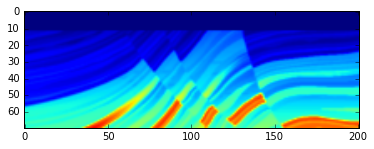

In [4]:
# Read velocity
vp = 1e-3*np.fromfile(currloc+'/../data/marmousi3D/MarmousiVP.raw', dtype='float32', sep="")

# print(np.shape(vp))
vp = vp.reshape(dimensions)

# This is a 3D model - extract a 2D slice 
# print(np.shape(vp))
vp = vp[101, :, :]
print(np.shape(vp))
dimensions = (201, 70)

# Create exact model
model = IGrid()
model.create_model(origin, spacing, vp)

# Plot true velocity
fig1 = plt.figure()
l = plt.imshow(np.transpose(vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

## Create "initial guess" by smoothening the synthetic velocity model.

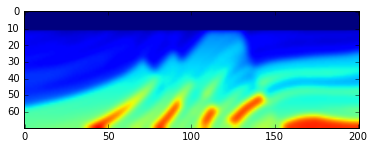

In [5]:
# Smooth velocity
smooth_vp = ndimage.gaussian_filter(vp, sigma=(2,2), order=0)

smooth_vp = np.max(vp)/np.max(smooth_vp)* smooth_vp

truc = (vp <= (np.min(vp)+.01))
smooth_vp[truc] = vp[truc]

# Create models
model = IGrid()
model0 = IGrid()

model.create_model(origin, spacing, vp)
model0.create_model(origin, spacing, smooth_vp)

# Plot smooth velocity
fig2 = plt.figure()
l = plt.imshow(np.transpose(smooth_vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

## Acquisition geometry (i.e. set up sources and receivers)

In [6]:
# Source function: Set up the source as Ricker wavelet for f0
def source(t, f0):
    r = (np.pi * f0 * (t - 1./f0))

    return (1-2.*r**2)*np.exp(-r**2)

# Define seismic data.
data = IShot()

f0 = .015
dt = model.get_critical_dt()
t0 = 0.0
tn = 1500
nt = int(1+(tn-t0)/dt)

time_series = source(np.linspace(t0, tn, nt), f0)
# plt.plot(time_series)

receiver_coords = np.zeros((101, 2))
receiver_coords[:, 0] = np.linspace(2 * spacing[0],
                                    origin[0] + (dimensions[0] - 2) * spacing[0],
                                    num=101)
receiver_coords[:, 1] = origin[1] + 2 * spacing[1]
data.set_receiver_pos(receiver_coords)
data.set_shape(nt, 101)

## Example of a shot record

GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/f0f76b3c4c931c3edc3ad39458549c0fd80fea94.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/a6b86acb0d7f636a87d3f7111a24ffb836107675.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/0b5240496a37b0b7a59ebf30bbd4852eec740b68.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/6911c4060b1adec3c2d556d9ce3bef0a457639bc.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/510341a268abaa6c8a7a9d932432bcc81dd7e84a.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/ce737c93ef58b36bb762548bf4423ee254aec478.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/628fee9c0cac24546b344f339182335470866400.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/2e4b288d8c9558927b4dd

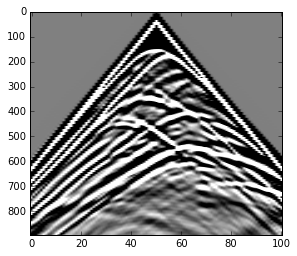

In [ ]:
location = (origin[0] + dimensions[0] * spacing[0] * 0.5,
            origin[1] + 2 * spacing[1])
data.set_source(time_series, dt, location)

# Create acoustic modelling kernel.
Acoustic = Acoustic_cg(model, data, t_order=2, s_order=10)

# Execute acoustic forward model
rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)

# Show the shot record at the receivers
fig3 = plt.figure()
l = plt.imshow(rec, vmin=-.1, vmax=.1, aspect=.1, cmap=cm.gray)
plt.show()

## RTM loop

In [ ]:
nsrc = 101
sources = np.linspace(2 * spacing[0], origin[0] + (dimensions[0] - 2) * spacing[0],num=nsrc)
grad = np.zeros(dimensions)
grad = np.pad(grad, [(40, 40),(40,40)],'edge')

for i in range(0,nsrc):
    print("Starting source : " + str(i+1) + " of " + str(nsrc))
    location = (sources[i] ,origin[1] + 2 * spacing[1])
    data.set_source(time_series, dt, location)
    # True data
    Acoustic = Acoustic_cg(model, data, t_order=2, s_order=4)
    rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)
    # Smooth data and wavefield
    Acoustic0 = Acoustic_cg(model0, data, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)
    # gradient
    grad =  grad + Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/05117b1cb45e748908683a40b35aceb6dd9c15ad.cpp


Starting source : 1over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/d1261fa61e230113877248eaccfa2a88d4f15291.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/74c276f43eec7f47c87470ff20e1c27fff4172c6.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/f4d6ab56894a9e560951a8f93a1b8a48c0541358.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/c10ec8644905a6303c687bb3befd3f858c68ae40.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/34ceec7f7384675e5abd206228b9b1790ab9ec98.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/9b4944b6b8e75a6b0838381c548e639b12d3f060.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/001d53bd93919d1977aefa51ca202a57476191b5.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.820900 s (44 MCells/s)
Stencil: 1.937500 OI, 1.43 GFlo

Starting source : 2over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/cd767f60e469eba4ecb17f080b84b49943871078.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/803f54ec361db77efa631d70fd6a87c865783cf6.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/b3ef7f644239aa5725e136e9035e74c2e448810c.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/fa19422374d94dd3a79fcbf6662d63d6682a8500.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/0661c9ce13fe431d954b9ad299759698a43d1ed7.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/5e97f40ea5abf00adab77b66fecc9a1dbdc4b963.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/44638d55c6a4de92d61ab0de0c199ffead200c20.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.848450 s (42 MCells/s)
Stencil: 1.937500 OI, 1.38 GFlo

Starting source : 3over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/b35f40af69bc36ac367df00aeb7ec150f7926da8.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/c9d738c0845196f44cf3e11d74885732f1ceb21c.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/7d90b4a4add65a32173519ab59a59d05ee6777c1.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/7ff77cb9e05584958c20756d10b7a4e9660097fb.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/2c53899681b3f59bdc04ee88c90dd891c65cf8aa.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/1d22000d75966f9ff18f1fe4c5608fdae7fe954b.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/6715c5c660706ba79228d9b44c33257365f62508.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.833065 s (43 MCells/s)
Stencil: 1.937500 OI, 1.41 GFlo

Starting source : 4over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/58e4e0bf7620936e0d86feed1530013a032bd826.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/58038c0055f62510536decb9a33c4528e4364add.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/72d5355d9645c53eb745f08b2eedf5cf0dc1e6b8.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/ed79fad147926423fdb28afc7379660c385a2a73.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/10c8d590590ea28a8418af2b1f89c3ccd4769b45.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/f193e14800ae9c744035c80d5f3eeba05858e661.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/d710d0b2d0d6e8b4c4b7a2001c65158790fff186.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.896977 s (40 MCells/s)
Stencil: 1.937500 OI, 1.31 GFlo

Starting source : 5over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/310f39695f97ae92fef2e3f65f3c43a7b54efcf0.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/1e44c3eaab1c9501f06bbd01955db1e963bc7c25.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/bccdb6d9982b158ff45cd18be30acc5910b2b312.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/77e2dc75f189b225806c7c21835a31f488826a41.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/ec61fa4335b9485ba03171b0402caa01e46dae49.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/a6ba18ca36779eb2b69324802b62d46ee57c275e.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/120b7ff91f858a297a212cfc0f53f000e4a6d270.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 1.216521 s (29 MCells/s)
Stencil: 1.937500 OI, 0.97 GFlo

Starting source : 6over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/227fb8636b475d9ed7978e9c3f9b0e5b11067239.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/23082da05079a2c22ceeadc1f0b3407e73c68a27.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/3839111c5bd9ecd2a3815e5515e3b7ad34c5c188.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/696edcb2b0a51fc1257560bcfc8ac8f31850863d.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/686fdb8cbae300a7f9d6abae167065b752ec67e6.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/91474e9f5f532141bd2eafb2605990656680c91e.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/a68ec396955eacacdd8e0b1d02832faadddc76d7.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.840966 s (43 MCells/s)
Stencil: 1.937500 OI, 1.39 GFlo

Starting source : 7over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/6b450f60510cbdcd84f36042fe27a7c7a7da23a4.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/0755cd1167e7505a54212196754eb441a5d4f74c.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/bc21ee1b69d772f79fa4d241ae9b34d93ce94688.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/41e2a8edbb7bb1c84ff0b344388f00c15b0307d5.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/a374cb31b17e51b63f2c8162c0811d7c7d44c7bc.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/6fdf1dffde0854d435106e493f4b154c2efb3b27.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/8eec375284da3ad4155c19f9583e36a3f0e4082b.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.833565 s (43 MCells/s)
Stencil: 1.937500 OI, 1.41 GFlo

Starting source : 8over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/e36992ac88ebdb3d24fe9431fa6fbab61999f0fc.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/bf0df7694fe49a6bd1ea82b980703fb980fbe8cf.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/1134cdfc0df5e9aaeea95ffedd04e5fd82b85185.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/19e51602a0e3a77ffd4e688980837e7f3ec56d0e.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/5e5c95ecbde520a03e1ee626844bd1dd10c8e8e7.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/b9ba66f2ce6f4ca09237222dea5d070a2fd073be.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/7e1a6eddb68ae147e03352bac7d073b91401ae2b.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.899675 s (40 MCells/s)
Stencil: 1.937500 OI, 1.31 GFlo

Starting source : 9over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/f1f92cad007a39a8be89aab379a0e611969fd6b2.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/f7747f8aa09b7f0934b816b77f9f59fa2aa733ed.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/29a1b71dfb8829604e630a4b18ae7ccba0b6b886.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/d87083f7c8706ba4bc8f41c8d4bb52e0f9f3413e.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/c158533f63286b04d08115cfcbc14e4160c99761.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/df0064eddeb2c6fda34cecef18c60cbcccb5b6b1.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/beb107178c9915afa5cbff4dd4162820049999a0.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 1.073600 s (33 MCells/s)
Stencil: 1.937500 OI, 1.10 GFlo

Starting source : 10over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/c0d8d3c8e9c7d85c201ce163e22afba7fb0b644e.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/00df142a10f29e4464d4935830b6e0dab8863d1e.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/13675cd023a70a94e442f17aaa83841939d6f0a1.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/7b1729ff9915cd469ca69f3fb5b0a8748ddea4d9.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/ed86fba76bce4dd772991cecad410628e432df87.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/c27c8f595d80313aa54cb2edffa9dab8ddf74ced.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/8812565a90ffc84b41130352357d5e8293696d7a.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.827744 s (43 MCells/s)
Stencil: 1.937500 OI, 1.42 GFlo

Starting source : 11over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/0e46865e302f42fbc57d6a58adf13870dcc25604.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/080789d80782c32789ab7c319e183c6bee420488.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/e1513c5f7e041b4714cf6bd63fd35d5a199a4ebd.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/e0e53fbffc0815e51ab90e2db79ac250102ca147.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/dee933921dcc4581e4150aee4fb6785143c1bf48.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/d048f915ee51e84a03408f8a1e4371025a02ae08.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/30a9ccfdf9e345d097ab102a3e0498f2ca80ed9b.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.848359 s (42 MCells/s)
Stencil: 1.937500 OI, 1.38 GFlo

Starting source : 12over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/aaff5d8c477c204c29bf9338d4f08ab40a6abd2e.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/9d932ed855c04103146bc866244e29764a155369.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/a9e203df46aa5ad6351347d086b75253467828cf.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/f2d65daaaab1178bff325fffa442aa2363f6c7fd.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/193fd1d2bede5c19ac8dcf0439110af6ff76e058.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/2d758c4760460efa2c7f0f614f2204f32bee3b82.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/48eb628eb737861968c9b2ac3a82391ebb92eca8.cpp
Shape: (281 x 150) - Cache Blocking: None
Time: 0.862625 s (41 MCells/s)
Stencil: 1.937500 OI, 1.36 GFlo

Starting source : 13over 101


GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/d35c74097260e9027eda31037a5220183a520c86.cpp


In [ ]:
# RTM result
fig4 = plt.figure()
l = plt.imshow(np.diff(np.diff(np.transpose(grad[40:-40,40:-40]),1,0),1), vmin=-100, vmax=100, aspect=1, cmap=cm.gray)
plt.show()
# Looks ok will rerun with better model

In [ ]:
# Shot record
fig5 = plt.figure()
l = plt.imshow(rec, vmin=-1, vmax=1, aspect=.1, cmap=cm.gray)
plt.show()

In [ ]:
# Shot record
fig6 = plt.figure()
l = plt.imshow(rec0, vmin=-1, vmax=1, aspect=.1, cmap=cm.gray)
plt.show()

In [ ]:
fig7 = plt.figure()
l = plt.imshow(rec0 - rec, vmin=-.1, vmax=.1, aspect=.1, cmap=cm.gray)
plt.show()